# Graph Dataset Analysis


In [12]:
import glob
import torch
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

In [3]:
dataset_path = "../data/sparse_test_data_totalnodes:20.pt"
dataset = torch.load(dataset_path)

In [4]:
def add_project_root(relative_to=".."):
    import os, sys
    project_root = os.path.abspath(os.path.join(os.getcwd(), relative_to))
    if project_root not in sys.path:
        sys.path.insert(0, project_root)

## Compute stats per graph

In [5]:
add_project_root(relative_to="..")
from graph.data_builder import DataConverter

In [16]:
node_types = {v: k for k, v in DataConverter.NODE_TYPES.items()}
directions       = {v: k for k, v in DataConverter.DIRECTIONS.items()}

records = []

for idx, (data, nest_id, food_id) in enumerate(dataset):
    x_np       = data.x.argmax(dim=1).numpy()
    edge_idx   = data.edge_index.numpy()
    edge_attr  = data.edge_attr.numpy()

    G = nx.DiGraph()
    
    # add nodes with the correct node_type
    for node_id, t_idx in enumerate(x_np):
        G.add_node(node_id, node_type=node_types[int(t_idx)])
    
    # add edges with distance & direction attrs
    for e in range(edge_idx.shape[1]):
        u, v = int(edge_idx[0, e]), int(edge_idx[1, e])
        dist, dir_idx = float(edge_attr[e, 0]), int(edge_attr[e, 1])
        G.add_edge(u, v,
                   distance=dist,
                   direction=directions[dir_idx])
    
    # get shortest‐path in terms of num of hops (edges)
    path_hops = nx.shortest_path(G, source=food_id, target=nest_id)
    d_fn_hops = len(path_hops) - 1
    # the sum of Euclidean distances along the shortest-distance path
    d_fn_distance = nx.shortest_path_length(
        G, source=food_id, target=nest_id, weight='distance'
    )

    # count distractors on the path between nest and food node
    num_distractors_on_path = sum(
        1 for v in path_hops[1:-1]
        if G.nodes[v]['node_type'] == 'distractor'
    )

    records.append({
        'sample':      idx,
        'd_fn_hops':   d_fn_hops,
        'd_fn_distance':   d_fn_distance,
        'num_distractors_on_path': num_distractors_on_path,
        'num_nodes':   G.number_of_nodes(),
        'num_edges':   G.number_of_edges(),
        'density':     nx.density(G.to_undirected()),
        'diameter':    nx.diameter(G.to_undirected()),
    })

df = pd.DataFrame(records)
print(df[['d_fn_hops','num_distractors_on_path','d_fn_distance']].describe())
df.head()

        d_fn_hops  num_distractors_on_path  d_fn_distance
count  200.000000               200.000000     200.000000
mean     3.575000                 2.575000     179.242717
std      1.361486                 1.361486      85.411030
min      2.000000                 1.000000      24.753931
25%      2.000000                 1.000000     114.659950
50%      3.000000                 2.000000     160.905233
75%      5.000000                 4.000000     232.367777
max      7.000000                 6.000000     516.163502


,sample,d_fn_hops,d_fn_distance,num_distractors_on_path,num_nodes,num_edges,density,diameter
0,0,4,273.102951,3,20,50,0.131579,8
1,1,5,286.917873,4,20,40,0.105263,12
2,2,3,128.911491,2,20,42,0.110526,9
3,3,4,154.195740,3,20,48,0.126316,7
4,4,2,105.336622,1,20,46,0.121053,6


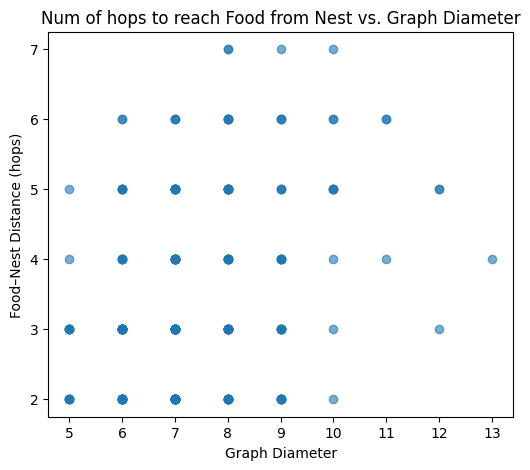

In [17]:
['d_fn_hops', 'diameter']
plt.figure(figsize=(6, 5))
plt.scatter(df['diameter'], df['d_fn_hops'], alpha=0.6)
# diameter is to know how far apart can two nodes be in the graph
plt.xlabel('Graph Diameter')
plt.ylabel('Food–Nest Distance (hops)')
plt.title('Num of hops to reach Food from Nest vs. Graph Diameter')
plt.show()
# each dot is a graph

count    200.000000
mean       0.487847
std        0.179368
min        0.200000
25%        0.333333
50%        0.500000
75%        0.600000
max        1.000000
Name: d_ratio, dtype: float64


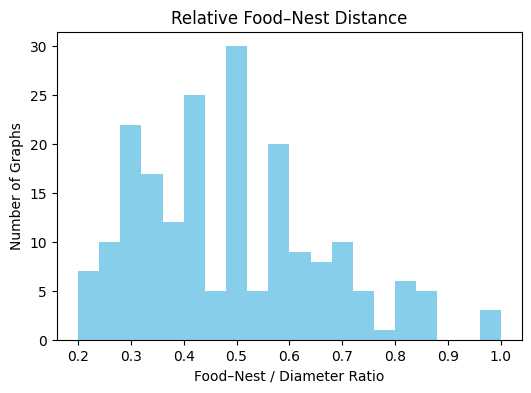

In [18]:
df['d_ratio'] = df['d_fn_hops'] / df['diameter']

print(df['d_ratio'].describe())

plt.figure(figsize=(6,4))
plt.hist(df['d_ratio'], bins=20, color='skyblue')
plt.xlabel('Food–Nest / Diameter Ratio')
plt.ylabel('Number of Graphs')
plt.title('Relative Food–Nest Distance')
plt.show()


## How increasing total num of nodes affect the complexity

In [13]:
node_types = {v: k for k, v in DataConverter.NODE_TYPES.items()}

def analyze_file(dataset_path):
    match = re.search(r'totalnodes:(\d+)', dataset_path)
    if not match:
        raise ValueError(f"Could not extract number of nodes from path: {dataset_path}")
    N = int(match.group(1))
    dataset = torch.load(dataset_path)
    
    rows = []
    for data, nest_id, food_id in dataset:
        G = nx.DiGraph()
        x = data.x.argmax(dim=1).numpy()
        ei = data.edge_index.numpy()
        ea = data.edge_attr.numpy()

        # nodes
        for i, t in enumerate(x):
            G.add_node(i, node_type=node_types[int(t)])
            
        # edges
        for e in range(ei.shape[1]):
            u,v = int(ei[0,e]), int(ei[1,e])
            dist, _ = ea[e]
            G.add_edge(u,v, distance=float(dist))
        
        path_hops = nx.shortest_path(G, source=food_id, target=nest_id)
        d_hops = len(path_hops)-1
        d_dist = nx.shortest_path_length(G,
                                         source=food_id,
                                         target=nest_id,
                                         weight='distance')
        n_d = d_hops - 1
        
        diameter = nx.diameter(G.to_undirected())
        ratio = d_hops / diameter
        
        rows.append({
            'num_nodes': N,
            'd_fn_hops': d_hops,
            'd_fn_distance': d_dist,
            'n_distractors_on_path': n_d,
            'ratio': ratio
        })
    return pd.DataFrame(rows)


In [14]:
all_dfs = []
for path in glob.glob('../data/sparse_train_data_totalnodes:*.pt'):
    dfN = analyze_file(path)
    all_dfs.append(dfN)
df = pd.concat(all_dfs, ignore_index=True)

summary = df.groupby('num_nodes').agg({
    'd_fn_hops':   ['mean','std'],
    'n_distractors_on_path':['mean','std'],
    'd_fn_distance':  ['mean','std'],
    'ratio':      ['mean','std']
}).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
summary

,num_nodes,d_fn_hops_mean,d_fn_hops_std,n_distractors_on_path_mean,n_distractors_on_path_std,d_fn_distance_mean,d_fn_distance_std,ratio_mean,ratio_std
0,2,1.00000,0.000000,0.00000,0.000000,51.450512,23.789920,1.000000,0.000000
1,10,2.87000,0.995912,1.87000,0.995912,143.949781,67.349596,0.567290,0.188550
2,20,3.74625,1.515662,2.74625,1.515662,187.182774,87.871698,0.507635,0.195549
3,30,4.26250,1.734894,3.26250,1.734894,211.714876,99.648431,0.482688,0.180989
4,50,4.89625,1.973031,3.89625,1.973031,238.085213,108.348791,0.462642,0.177924


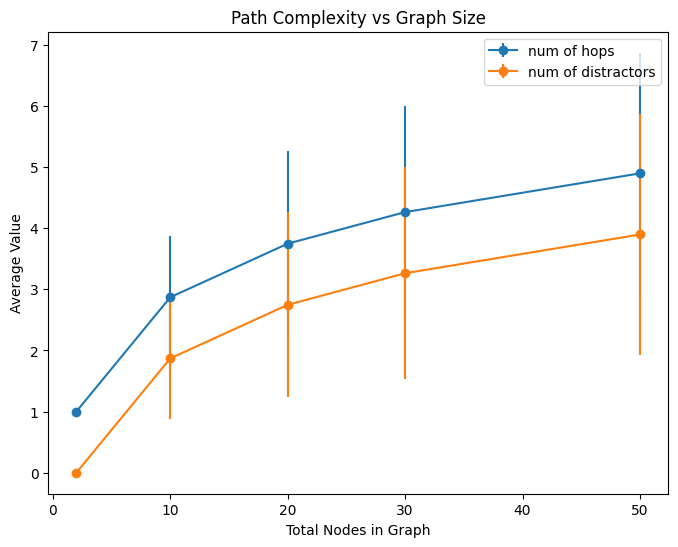

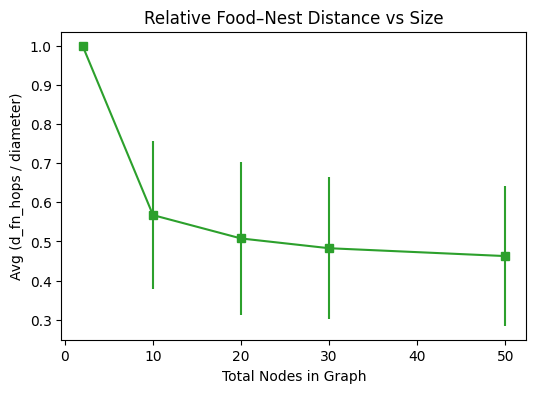

In [15]:
plt.figure(figsize=(8,6))
plt.errorbar(summary['num_nodes'],
             summary['d_fn_hops_mean'],
             yerr=summary['d_fn_hops_std'],
             marker='o', label='num of hops')
plt.errorbar(summary['num_nodes'],
             summary['n_distractors_on_path_mean'],
             yerr=summary['n_distractors_on_path_std'],
             marker='o', label='num of distractors')
plt.xlabel('Total Nodes in Graph')
plt.ylabel('Average Value')
plt.title('Path Complexity vs Graph Size')
plt.legend()
plt.show()

# relative ratio
plt.figure(figsize=(6,4))
plt.errorbar(summary['num_nodes'],
             summary['ratio_mean'],
             yerr=summary['ratio_std'],
             marker='s', color='C2')
plt.xlabel('Total Nodes in Graph')
plt.ylabel('Avg (d_fn_hops / diameter)')
plt.title('Relative Food–Nest Distance vs Size')
plt.show()
